In [1]:
import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

import cPickle as pkl
from scipy import stats as spstats

from pipeline.python.classifications import responsivity_stats as resp
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import get_dataset_stats as ds
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applicat

In [2]:
from pipeline.python.retinotopy import convert_coords as cc


In [3]:
# Set output dir:

In [4]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

In [5]:
rfdir = os.path.join(aggregate_dir, 'rfs')
if not os.path.exists(rfdir):
    os.makedirs(rfdir)

In [6]:
#reload(fitrf)

In [7]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
response_type = 'dff'
traceid='traces001'
trace_type= 'corrected'
responsive_test = 'ROC'
fit_thr=0.5

In [8]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print(fit_desc)

fit-2dgaus_dff-no-cutoff


In [9]:
data_desc = '-'.join([traceid, trace_type, response_type, responsive_test])

data_identifier = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print(data_identifier)

traces001-corrected-dff-ROC|fit-2dgaus_dff-no-cutoff-thr-0.50


In [10]:
sdata = ds.aggregate_session_info()

[JC084] Li - skipping
[JC091] V1 - skipping
[JC085] Lm - skipping
[JC085] Li - skipping
[JC090] V1 - skipping
[JC090] Lm - skipping
[JC099] V1 - skipping
[JC099] Lm - skipping
[JC097] Lm - skipping
[JC097] Li - skipping
[JC078] V1 - skipping
[JC078] Li - skipping
[JC080] V1 - skipping
[JC083] Li - skipping


In [11]:
sdata.head()

animalid experiment            fov   session visual_area
0    JC084        rfs  FOV1_zoom2p0x  20190522          V1
1    JC084   gratings  FOV1_zoom2p0x  20190522          V1
2    JC084      blobs  FOV1_zoom2p0x  20190522          V1
3    JC084     retino  FOV1_zoom2p0x  20190522          V1
4    JC084        rfs  FOV1_zoom2p0x  20190525          Lm

In [12]:
sdata['experiment'].unique()

array(['rfs', 'gratings', 'blobs', 'retino', 'rfs10'], dtype=object)

In [13]:
sdata[sdata['experiment'].isin(['rfs', 'rfs10'])].shape

(39, 5)

In [14]:
rf_sdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
fit_these = []
dpaths = []
unknown = []
for animalid in rf_sdata['animalid'].unique():
    sessions = rf_sdata[rf_sdata['animalid']==animalid]['session'].unique()
    for session in sessions:
        rfruns = rf_sdata[(rf_sdata['animalid']==animalid) & (rf_sdata['session']==session)]['experiment'].unique()
        fovs = rf_sdata[(rf_sdata['animalid']==animalid) & (rf_sdata['session']==session)]['fov'].unique()
        for fov in fovs:
            for rfname in rfruns:
                if int(session) < 20190511:
                    f = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                                'combined_gratings*', 'traces', '%s*' % traceid, 
                                                'receptive_fields', fit_desc, 'fit_results.pkl'))
                else:
                    f = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                                'combined_%s*' % rfname, 'traces', '%s*' % traceid, 
                                                'receptive_fields', fit_desc, 'fit_results.pkl'))
                if len(f) > 0:
                    for fi in f:
                        if fi not in dpaths:
                            dpaths.append(fi)
                elif len(f) == 0:
                    fit_these.append((animalid, session, fov, rfname))
                else:
                    unknown.append((animalid, session, fov, rfname))
            

In [15]:
rf_sdata.tail()

animalid experiment            fov   session visual_area
108    JC083        rfs  FOV1_zoom2p0x  20190507          V1
109    JC083        rfs  FOV1_zoom2p0x  20190511          V1
113    JC083        rfs  FOV1_zoom2p0x  20190512          Lm
117    JC083        rfs  FOV1_zoom2p0x  20190517          Lm
123    JC083        rfs  FOV1_zoom2p0x  20190508          Lm

In [16]:
rf_sdata['path'] = dpaths

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
for (animalid, session, fov, run_name) in fit_these:
    nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

In [18]:
len(dpaths)

39

In [19]:
assert (len(dpaths) + len(fit_these) + len(unknown)) == rf_sdata.shape[0]

In [20]:
# Load session stats for relevant datasets

In [21]:
rf_sdata.head()

animalid experiment            fov   session visual_area  \
0     JC084        rfs  FOV1_zoom2p0x  20190522          V1   
4     JC084        rfs  FOV1_zoom2p0x  20190525          Lm   
8     JC091        rfs  FOV1_zoom2p0x  20190627          Lm   
12    JC091      rfs10  FOV1_zoom2p0x  20190607          Li   
16    JC091      rfs10  FOV1_zoom2p0x  20190614          Li   

                                                 path  
0   /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0...  
4   /n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0...  
8   /n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0...  
12  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...  
16  /n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0...

In [22]:
fit_thr = 0.5

df_list = []
for visual_area in ['V1', 'Lm', 'Li']:
    #df_list = []

    #visual_area = 'V1'
    for fpath in rf_sdata[rf_sdata['visual_area']==visual_area]['path']:

        parentdir = fpath.split('/traces')[0]
        run_name = os.path.split(parentdir)[-1]
        fov = os.path.split(os.path.split(parentdir)[0])[-1]
        session = os.path.split(parentdir.split('/%s' % fov)[0])[-1]
        animalid = os.path.split(parentdir.split('/%s' % session)[0])[-1]

        with open(fpath,'rb') as f:
            rfits = pkl.load(f)

        roi_list = [r for r, res in rfits['fit_results'].items() if res['fit_r']['r2'] >= fit_thr]
        fitdf = fitrf.rfits_to_df(rfits['fit_results'], 
                                row_vals=rfits['row_vals'],
                                col_vals=rfits['col_vals'],
                                roi_list=sorted(roi_list))
        nsamples = fitdf.shape[0]
        fitdf['cell'] = fitdf.index.tolist()
        fitdf['animalid'] = [animalid for _ in range(nsamples)]
        fitdf['session'] = [session for _ in range(nsamples)]
        fitdf['visual_area'] = [visual_area for _ in range(nsamples)]
        fitdf['fov'] = [fov for _ in range(nsamples)]

        df_list.append(fitdf)

    #dfs[visual_area] = pd.concat(df_list, axis=0).reset_index()

In [23]:
df = pd.concat(df_list, axis=0).reset_index()

In [24]:
df.groupby(['visual_area']).count()

index    r2  sigma_x  sigma_y  theta    x0    y0  cell  animalid  \
visual_area                                                                     
Li             502   502      502      502    502   502   502   502       502   
Lm             439   439      439      439    439   439   439   439       439   
V1            1277  1277     1277     1277   1277  1277  1277  1277      1277   

             session   fov  
visual_area                 
Li               502   502  
Lm               439   439  
V1              1277  1277

In [25]:
sigma_scale = 2.35

In [26]:
df['sigma_x'] = df['sigma_x']*sigma_scale
df['sigma_y'] = df['sigma_y']*sigma_scale


In [27]:
df['avg_size'] = df[['sigma_x', 'sigma_y']].mean(axis=1)

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


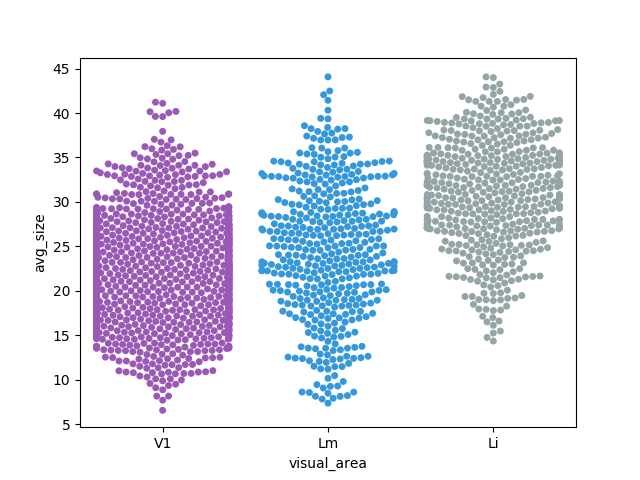

In [35]:
pl.figure()
sns.swarmplot(x="visual_area", y="avg_size", data=df)

In [127]:
df[df['visual_area']==visual_area].shape

(502, 13)

In [36]:
visual_area

'Li'

In [37]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


In [507]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

<IPython.core.display.Javascript object>


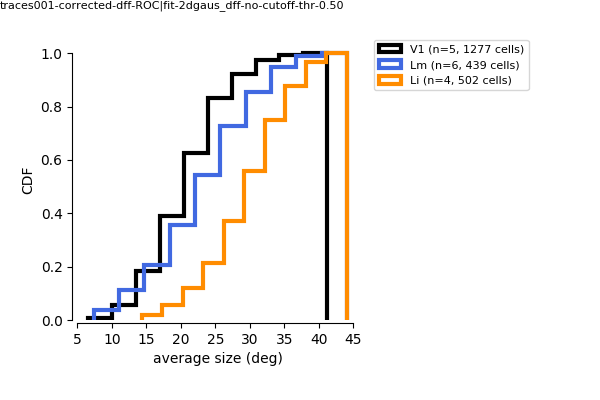

In [508]:
fig, ax = pl.subplots(figsize=(6,4))
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
    ncells_total = df[df['visual_area']==visual_area].shape[0]
    values = df[df['visual_area']==visual_area]['avg_size'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('average size (deg)')
ax.set_ylabel('CDF')
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'cdf_average_rf_size.png'))

<IPython.core.display.Javascript object>


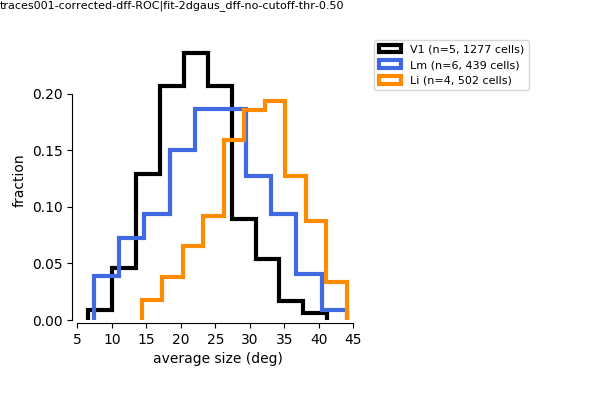

In [31]:
fig, ax = pl.subplots(figsize=(6,4))
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
    ncells_total = df[df['visual_area']==visual_area].shape[0]
    values = df[df['visual_area']==visual_area]['avg_size'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('average size (deg)')
ax.set_ylabel('fraction')
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'hist_average_rf_size.png'))

In [40]:
visual_area = 'V1' 
d = df[df['visual_area']==visual_area]


In [42]:
d.head()

index        r2    sigma_x    sigma_y     theta         x0         y0  \
0      0  0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018   
1      2  0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950   
2      5  0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272   
3      9  0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018   
4     11  0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   

   cell animalid   session visual_area            fov   avg_size  
0   0.0    JC084  20190522          V1  FOV1_zoom2p0x  19.718773  
1   2.0    JC084  20190522          V1  FOV1_zoom2p0x  17.783601  
2   5.0    JC084  20190522          V1  FOV1_zoom2p0x  22.976834  
3   9.0    JC084  20190522          V1  FOV1_zoom2p0x  21.722232  
4  11.0    JC084  20190522          V1  FOV1_zoom2p0x  19.205308

In [43]:
reload(cc)

<module 'pipeline.python.retinotopy.convert_coords' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/convert_coords.pyc'>

In [32]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = cc.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = cc.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


In [36]:
get_postions = False
pos_fpath = os.path.join(aggregate_dir, 'rfs', 'rf_positions.pkl')

if os.path.exists(pos_fpath):
    try:
        with open(pos_fpath, 'rb') as f:
            aggr = pkl.load(f)
            posdf = aggr['posdf']
    except Exception as e:
        get_positions = True
else:
    get_positions = True
    

In [37]:

if get_positions:
    pos_list = []
    for visual_area in visual_areas:
        d = df[df['visual_area']==visual_area]
        for (animalid, session, fov), g in d.groupby(['animalid', 'session', 'fov']):
            rffits = g.copy()
            rffits.index = g['index']
            posdf = get_fov_coordinates(animalid, session, fov, rffits)
            pos_list.append(posdf)


[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
... loaded


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:877: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


... offset: 251.51
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC076] 20190501 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190501|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
... loaded
... offset: 282.72
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 242 contours for rois.
[JC083] 20190507 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190507 | FOV1_zoom2p0x)
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
...

... offset: 624.53
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 293 contours for rois.
[JC078] 20190504 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC078|20190504|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
... loaded
... offset: 370.09
... making equal
Checking counts / condition...
... incorrect reps / condn...
... updating self
... ... loaded traces
Created 267 contours for rois.
[JC078] 20190509 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC078 | 20190509 | FOV1_zoom2p0x)
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loa

... offset: 398.90
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 271 contours for rois.
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... ... combined_rfs10_static
... renaming experiment to run name: combined_rfs10_static
... loading data array (combined_rfs10_static - datasets.npz)
... loaded
... offset: 337.46
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 356 contours for rois.
[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190606|FOV1_z

In [38]:
posdf = pd.concat(pos_list, axis=0).reset_index()
with open(pos_fpath, 'wb') as f:
    aggr = {'posdf': posdf}
    pkl.dump(aggr, f, protocol=pkl.HIGHEST_PROTOCOL)

In [153]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

def calculate_distance(df):
    
    regr = LinearRegression()
    xv = np.array(df['xpos_fov']).reshape(-1, 1) 
    yv = np.array(df['xpos_rf']).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['dist_az'] = yv - fitv

    mse_az = skmetrics.mean_squared_error(yv, fitv)
    var_az = skmetrics.r2_score(yv, fitv)
    df['mse_az'] = [mse_az for _ in range(len(fitv))]
    df['var_az'] = [var_az for _ in range(len(fitv))]
    
    regr = LinearRegression()
    xv = np.array(df['ypos_fov']).reshape(-1, 1) 
    yv = np.array(df['ypos_rf']).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['dist_el'] = yv - fitv
    
    mse_el = skmetrics.mean_squared_error(yv, fitv)
    var_el = skmetrics.r2_score(yv, fitv, multioutput='variance_weighted')
    df['mse_el'] = [mse_el for _ in range(len(fitv))]
    df['var_el'] = [var_el for _ in range(len(fitv))]
    
    return df

In [148]:
tmpd = posdf.groupby(['animalid', 'session', 'fov']).get_group(('JC084', '20190522', 'FOV1_zoom2p0x'))


In [151]:
regr = LinearRegression()
xv = np.array(tmpd['xpos_fov']).reshape(-1, 1) 
yv = np.array(tmpd['xpos_rf']).reshape(-1, 1)
regr.fit(xv, yv)
fitv = regr.predict(xv)

mse_az = skmetrics.mean_squared_error(yv, fitv)
var_az = skmetrics.r2_score(yv, fitv, multioutput='variance_weighted')
print mse_az, var_az

4.94194665707 0.803991439656


In [152]:
mse_az = skmetrics.mean_squared_error(yv, fitv, multioutput='raw_values')
print mse_az

[ 4.94194666]


<IPython.core.display.Javascript object>


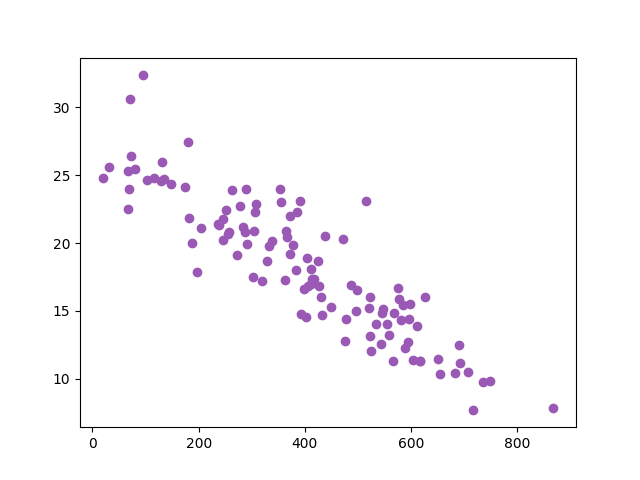

In [52]:
pl.figure()
xv = tmpd['xpos_fov']
yv = tmpd['xpos_rf']
pl.scatter(xv, yv)
    

In [154]:
pf = pd.concat([calculate_distance(g) for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0).reset_index(drop=True)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is t

In [156]:
pf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf   dist_az     mse_az   var_az   dist_el   mse_el  \
0  273.349886  5.655262  3.816403  15.694643  0.68203  2.608741  3.75284   
1  125.092321  1.460737 -2.346039  15.694643  0.68203 -3.114970  3.75284   
2  356.744767  4.182264  0.701298  15.694643  0.68203  1.995910  3.75284   
3  403.075256  2.775072  3.692497  15.694643  0.68203  1.066589  3.75284   
4  379.910012  2.955575  3.833411  15.694643  0.68203  1.008156  3.75284   

     var_el  
0  0.676879  
1  0.676879  
2  0.676879  
3  0.676879  
4  0.676879

<IPython.core.display.Javascript object>


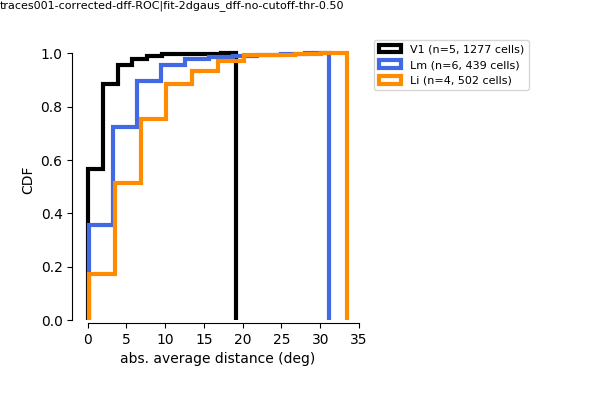

In [509]:
fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('abs. average distance (deg)')
ax.set_ylabel('CDF')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'average_distance_from_regr_cdf.png'))

<IPython.core.display.Javascript object>


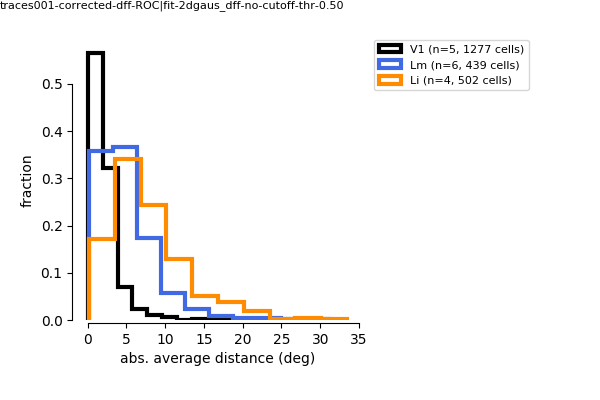

In [510]:
fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('abs. average distance (deg)')

ax.set_ylabel('fraction')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'average_distance_from_regr_hist.png'))

In [57]:
pf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf   dist_az     mse_az   var_az   dist_el   mse_el  \
0  273.349886  5.655262  3.816403  15.694643  0.68203  2.608741  3.75284   
1  125.092321  1.460737 -2.346039  15.694643  0.68203 -3.114970  3.75284   
2  356.744767  4.182264  0.701298  15.694643  0.68203  1.995910  3.75284   
3  403.075256  2.775072  3.692497  15.694643  0.68203  1.066589  3.75284   
4  379.910012  2.955575  3.833411  15.694643  0.68203  1.008156  3.75284   

     var_el  
0  0.676879  
1  0.676879  
2  0.676879  
3  0.676879  
4  0.676879

In [ ]:
# Look at cortical vs. RF position for EACH session

In [451]:
for k, g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    print k

('Li', 'JC076', '20190502', 'FOV1_zoom2p0x')
('Li', 'JC090', '20190605', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190602', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190606', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190607', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190614', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190609', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190612', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190617', 'FOV1_zoom2p0x')
('Lm', 'JC076', '20190423', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190430', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190504', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190509', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190513', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190506', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190602', 'FOV2_zoom2p0x')
('Lm', 'JC080', '20190603', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190508', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190512', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190517', 'FOV1_zoom2p0x')
('Lm', 'JC084', '20190525', 'FOV1_zoom2p0x')
('Lm', 'JC091', '20190627', 'FOV1_zoom2p0x')
('V1', 'JC

In [452]:
g.head()

index animalid            fov   session visual_area    xpos_fov  \
2021      4    JC097  FOV1_zoom2p0x  20190617          V1   49.600877   
2022     20    JC097  FOV1_zoom2p0x  20190617          V1  173.603068   
2023     21    JC097  FOV1_zoom2p0x  20190617          V1  236.558027   
2024     24    JC097  FOV1_zoom2p0x  20190617          V1  307.143890   
2025     25    JC097  FOV1_zoom2p0x  20190617          V1  337.667507   

        xpos_rf    ypos_fov   ypos_rf    dist_az     mse_az    var_az  \
2021  33.255038  169.106286  1.406981  -0.686232  13.197615  0.660591   
2022  16.052843  145.941041  7.205323 -15.161039  13.197615  0.660591   
2023  28.738744   92.660978  3.445238  -1.090464  13.197615  0.660591   
2024  31.015781   48.647014  3.931382   2.739087  13.197615  0.660591   
2025  30.329007   69.495734  4.006957   2.723670  13.197615  0.660591   

       dist_el    mse_el    var_el  
2021  0.228410  9.384165  0.531177  
2022  5.746141  9.384165  0.531177  
2023  1.340649  9.384165  0.531177  
2024  1.293631  9.384165  0.531177  
2025  1.621757  9.384165  0.531177

In [ ]:
# create output dir for visual area plots

In [471]:
retinodir = os.path.join(rfdir, 'retinotopic-organization')
curr_outdir = os.path.join(rfdir, 'retinotopic-organization', 'sessions')
if not os.path.exists(curr_outdir):
    os.makedirs(curr_outdir)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<IPython.core.display.Javascript object>


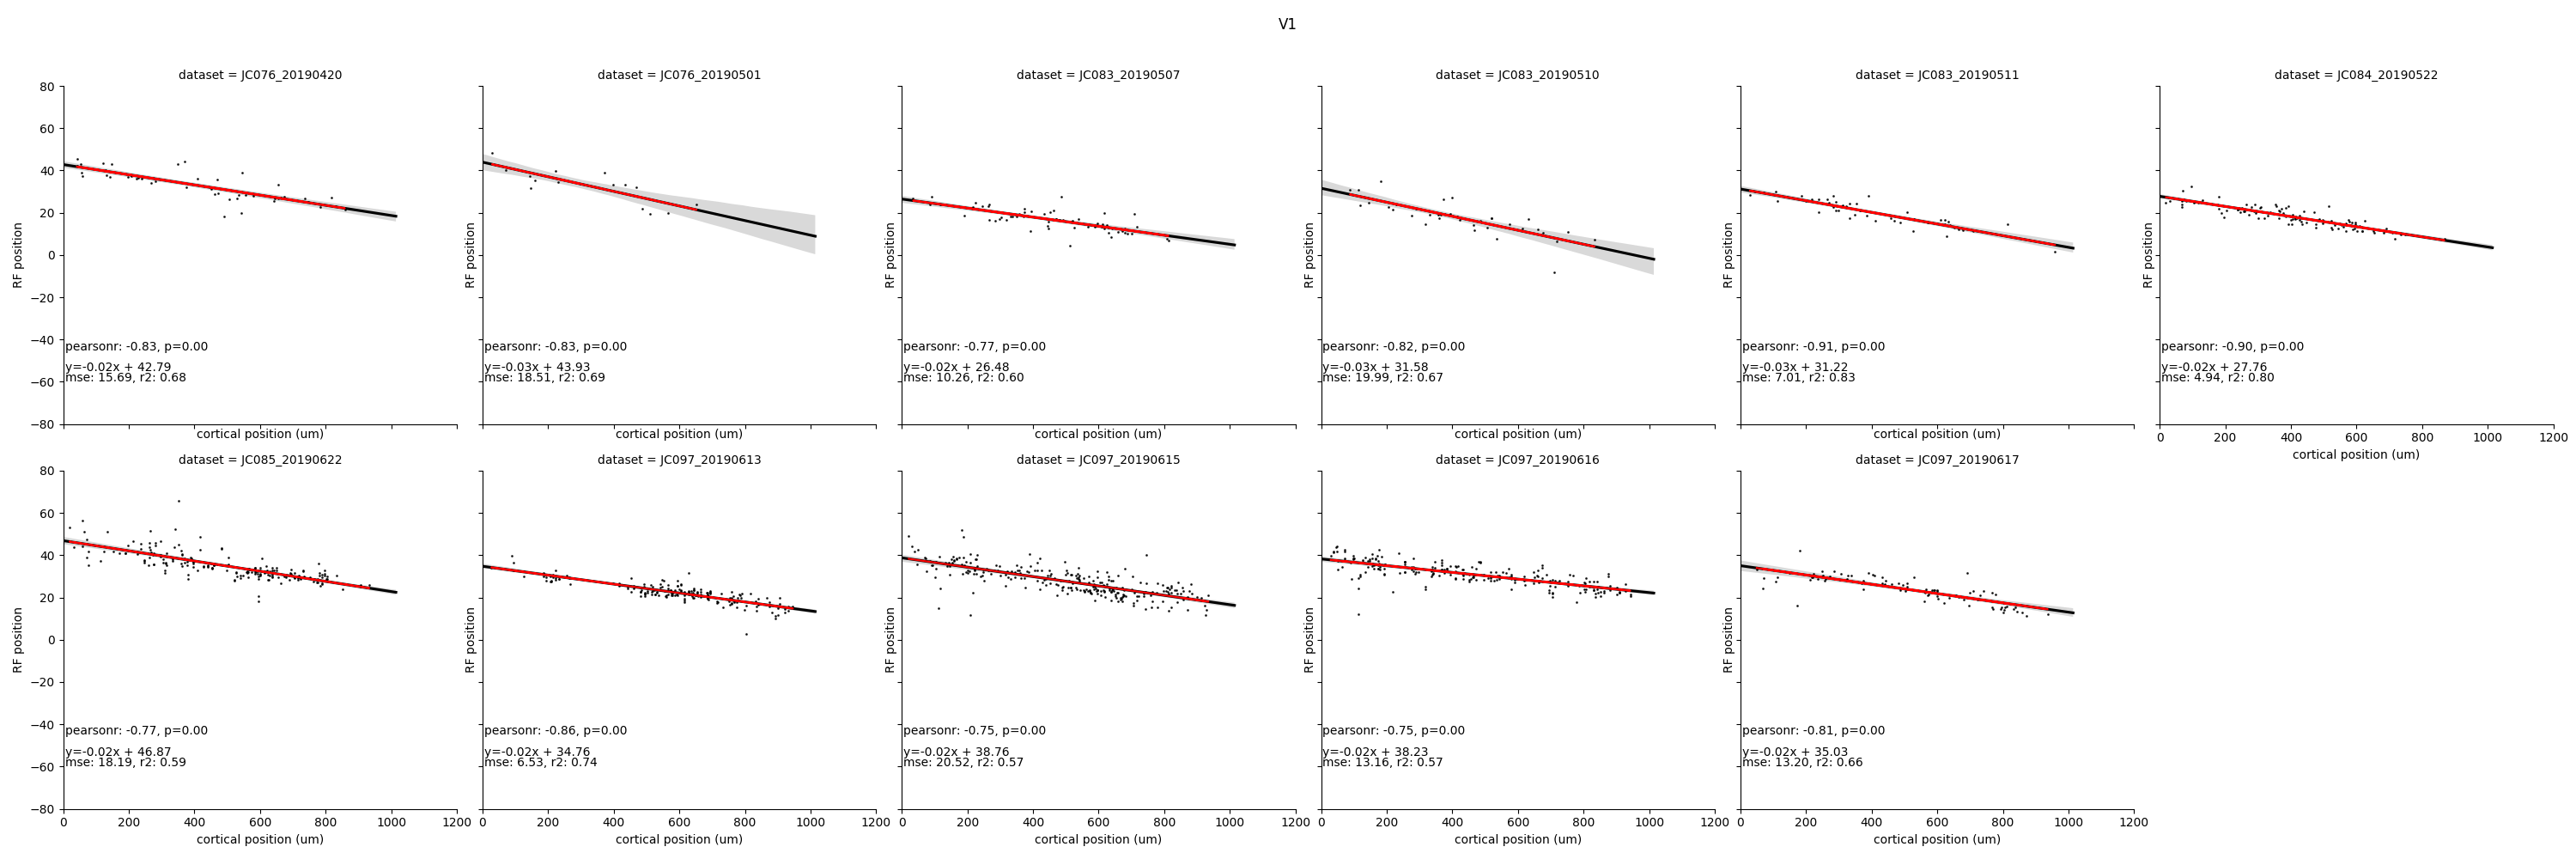

<IPython.core.display.Javascript object>


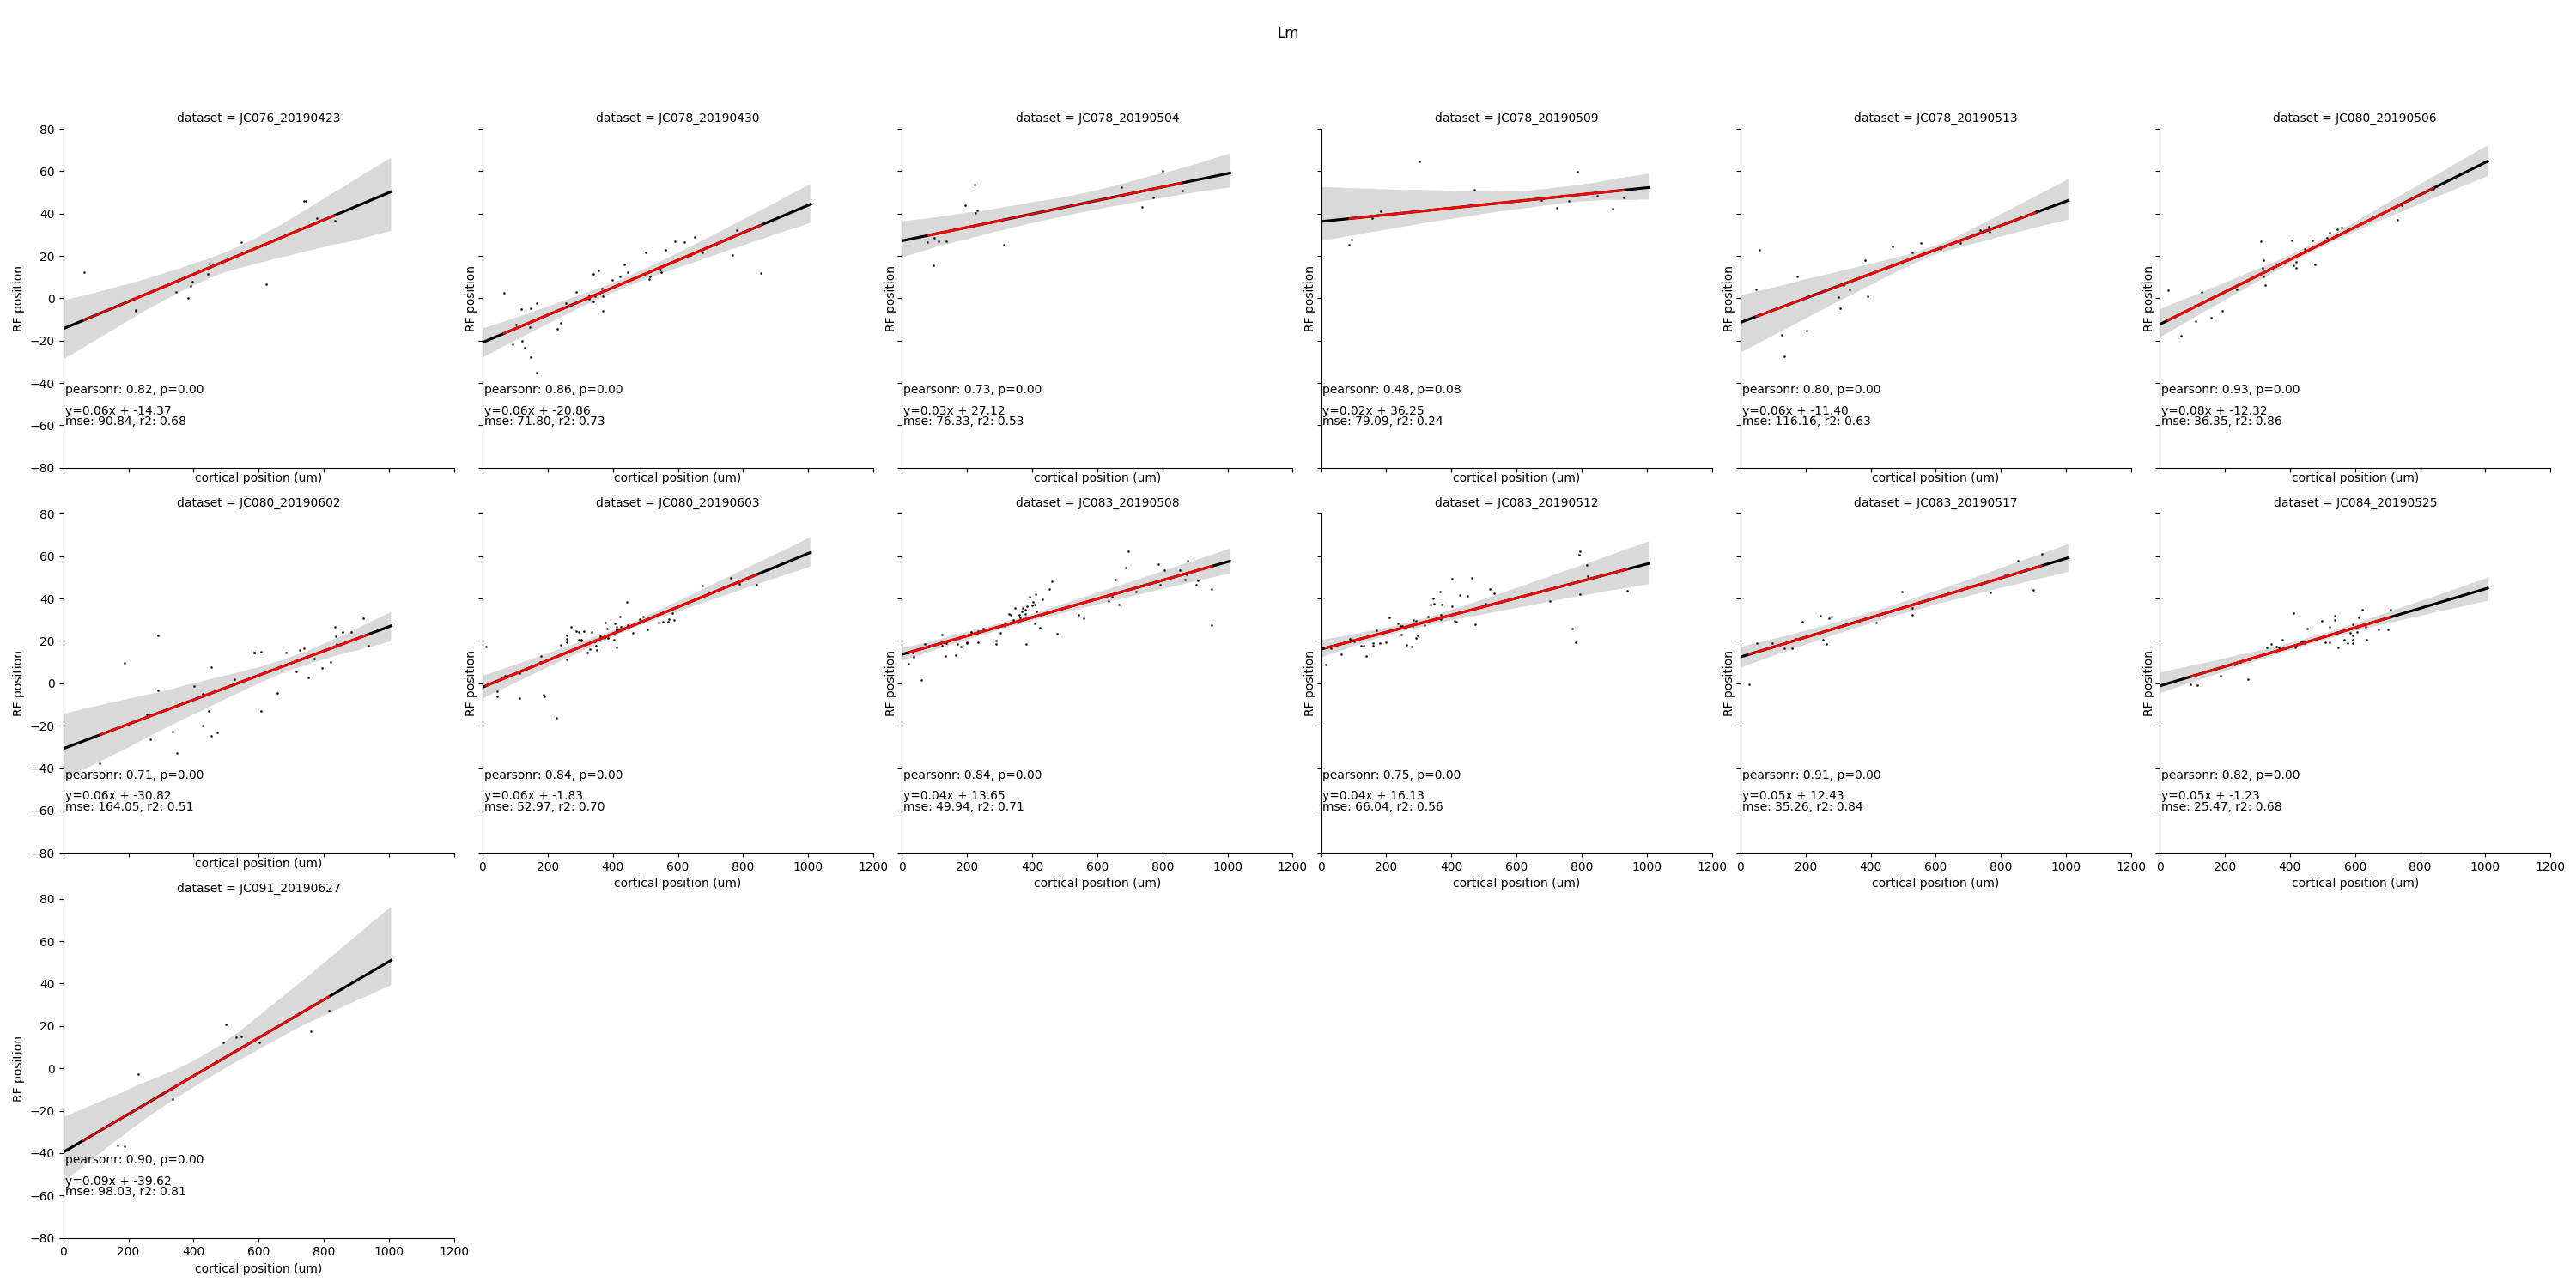

<IPython.core.display.Javascript object>


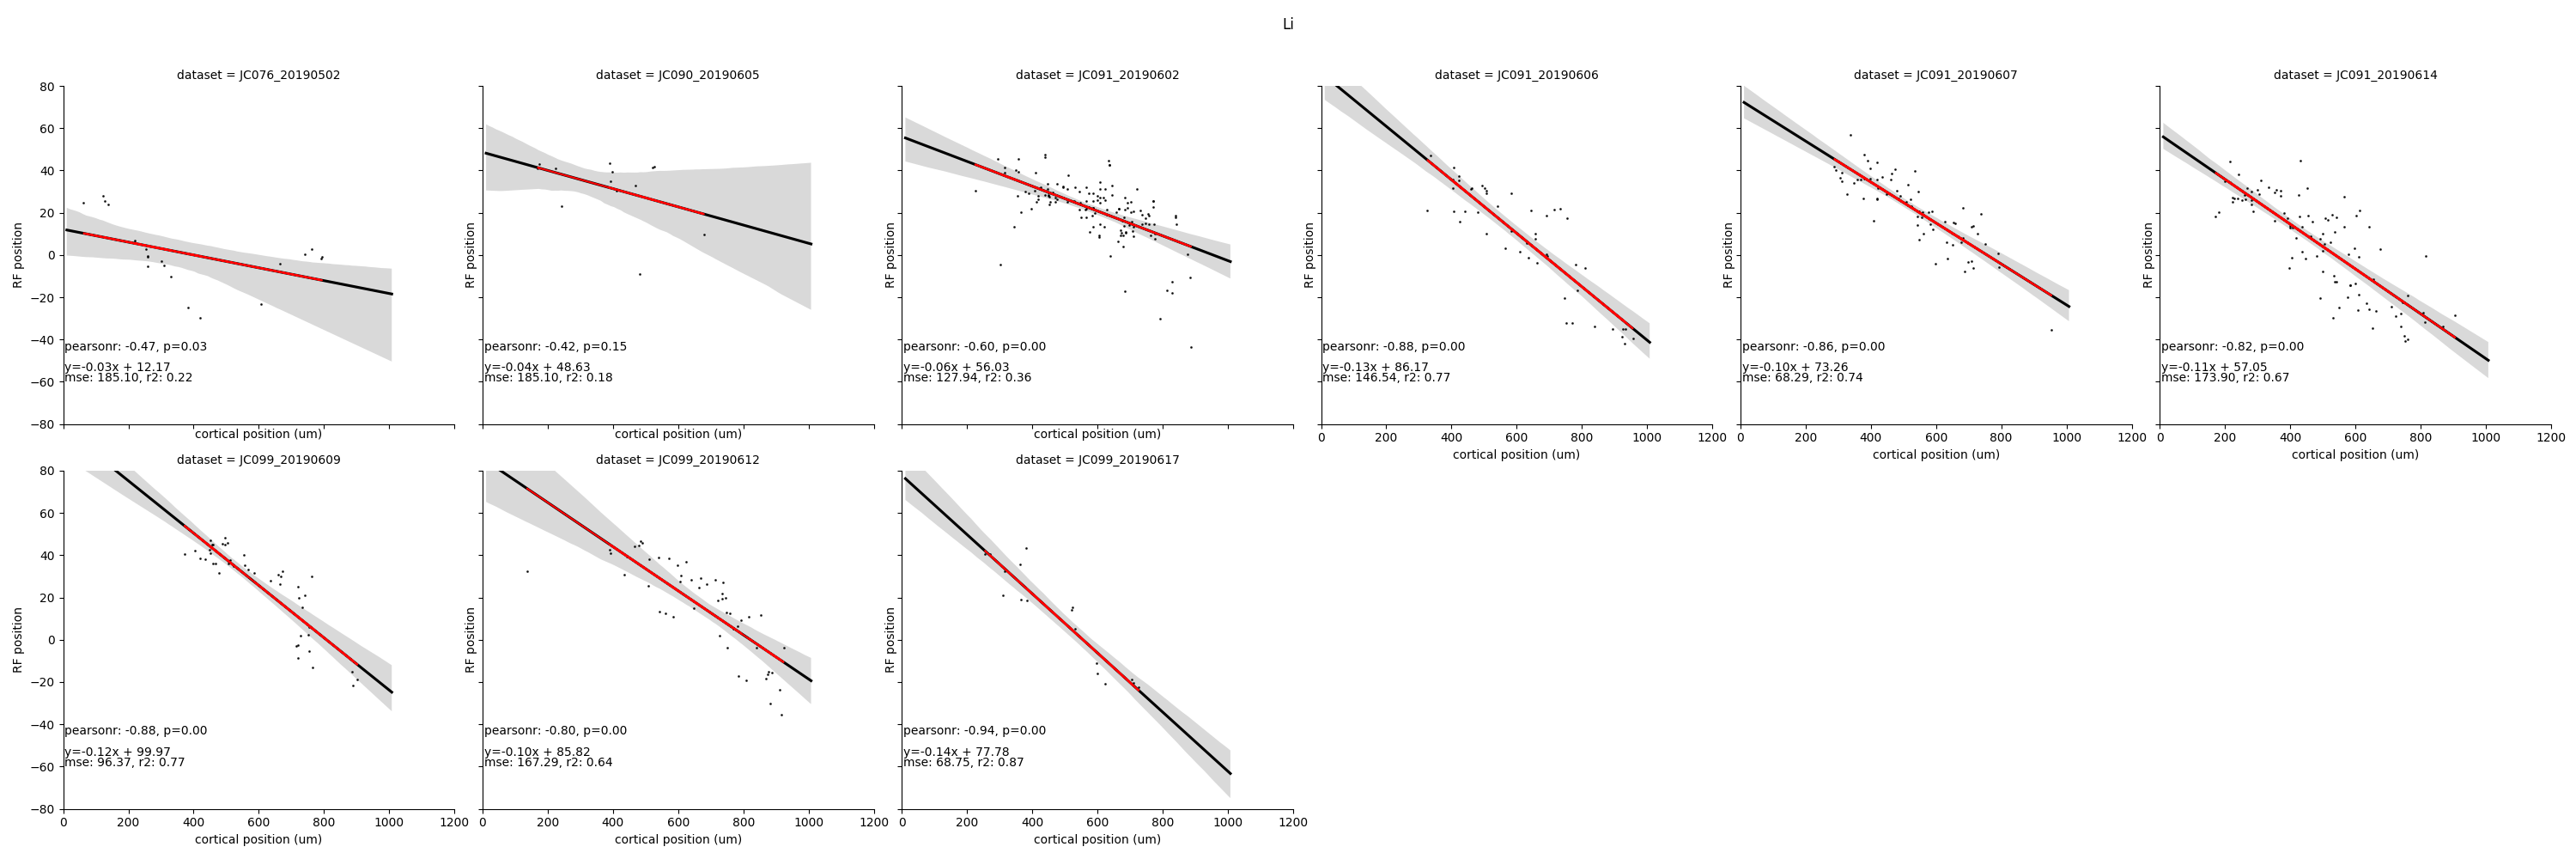

In [462]:
regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]
    tmpd['dataset'] = ['%s_%s' % (a, s) for a, s, in zip(tmpd['animalid'], tmpd['session'])]

    # Plot regression w/ CI
    g = sns.lmplot('xpos_fov', 'xpos_rf', data=tmpd, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = tmpd[tmpd['dataset']==curr_dset]['xpos_fov']
        yv = tmpd[tmpd['dataset']==curr_dset]['xpos_rf']
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        ax.text(5, -45, stat_str)
        ax.set_ylim([-80, 80])
        ax.set_xlim([0, 1200])
        ax.set_xlabel('cortical position (um)')
        ax.set_ylabel('RF position')
        
        # Fit line
        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.text(5, -55, slope_str)
        ax.text(5, -60, regr_str)
        regr_stats.append(pd.Series({'dataset': curr_dset,
                                   'mse': mse,
                                   'slope': float(regr.coef_),
                                   'intercept': float(regr.intercept_),
                                   'r2': r2,
                                     'pearsonr': p,
                                    'visual_area': visual_area}))

    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_outdir, '%s.png' % visual_area))


In [ ]:
# Plot some stats 

In [467]:
retinostats = pd.concat(regr_stats, axis=1).T

In [468]:
retinostats.head()

dataset intercept      mse  pearsonr        r2      slope  \
0  JC076_20190420   42.7858  15.6946 -0.825851   0.68203  -0.024101   
1  JC076_20190501   43.9296  18.5065 -0.830974  0.690518 -0.0345589   
2  JC083_20190507   26.4769  10.2552 -0.772604  0.596916  -0.021411   
3  JC083_20190510   31.5783  19.9897 -0.816761  0.667099 -0.0331167   
4  JC083_20190511   31.2174  7.00883  -0.90918  0.826608 -0.0275863   

  visual_area  
0          V1  
1          V1  
2          V1  
3          V1  
4          V1

In [474]:
retinostats['slope'] = retinostats['slope'].astype(float)

In [554]:
def boxplot_visual_area(df, metric='slope', ax=None, area_colors=None):
    df[metric] = df[metric].astype(float)
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    sns.boxplot(x='visual_area', y=metric, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metric, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'r2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metric].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax


In [549]:
# Plot regression stats by visual area

0.14000786310663918

<IPython.core.display.Javascript object>


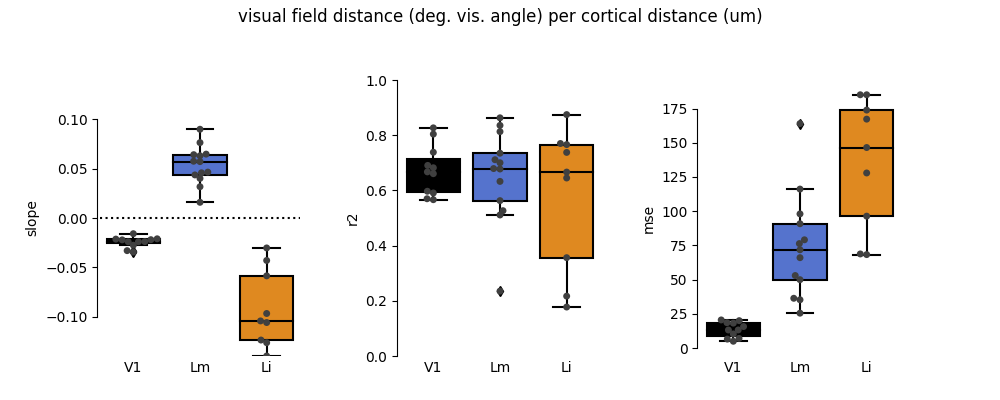

In [551]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(retinostats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(retinostats, metric='r2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(retinostats, metric='mse', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('visual field distance (deg. vis. angle) per cortical distance (um)')

pl.savefig(os.path.join(retinodir, 'regression_stats.png'))

In [480]:
retinostats['r2'] = retinostats['r2'].astype(float)

<IPython.core.display.Javascript object>


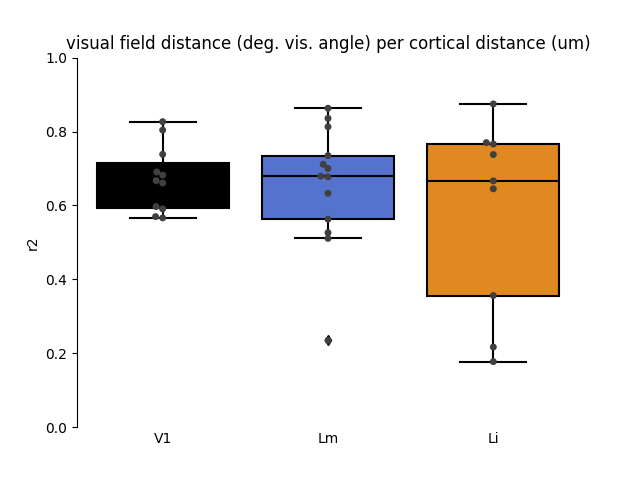

In [493]:
fig, ax = pl.subplots()
fig.patch.set_alpha(1)
sns.boxplot(x='visual_area', y='r2', data=retinostats, ax=ax, palette=area_colors)
ax = sns.swarmplot(x='visual_area', y='r2', data=retinostats, color=".25")
ax.set_ylim([0, 1])

sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
pl.savefig(os.path.join(retinodir, 'r2_CTX-vs-VF-regr_box.png'))

In [490]:
retinostats['pearsonr'] = retinostats['pearsonr'].astype(float)
retinostats['pearsonr-abs'] = np.abs(retinostats['pearsonr'].astype(float))


<IPython.core.display.Javascript object>


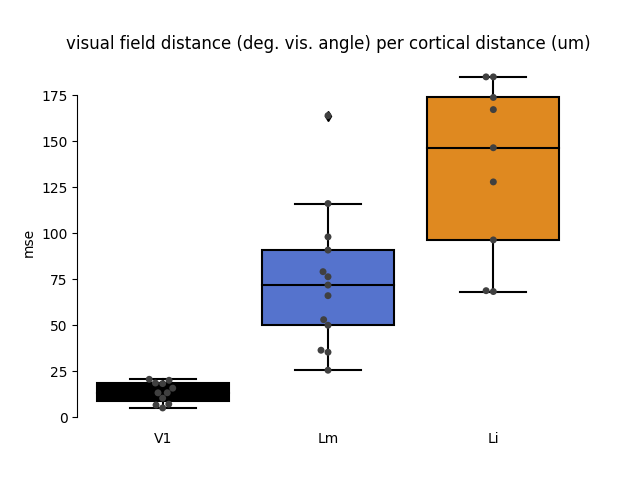

In [500]:
metric = 'mse'
retinostats[metric] = retinostats[metric].astype(float)

fig, ax = pl.subplots()
fig.patch.set_alpha(1)
sns.boxplot(x='visual_area', y=metric, data=retinostats, ax=ax, palette=area_colors)
ax = sns.swarmplot(x='visual_area', y=metric, data=retinostats, color=".25")
if metric == 'pearsonr':
    ax.set_ylim([-1, 1])
elif metric in ['pearsonr-abs', 'r2']:
    ax.set_ylim([0, 1])

sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
pl.savefig(os.path.join(retinodir, '%s_CTX-vs-VF-regr_box.png' % metric))

In [162]:
column_names = ['visual_area', 'animalid', 'fov', 'session']
var_names = ['mse_el', 'var_el', 'mse_az', 'var_az']
column_names.extend(var_names)

residuals = pd.concat([pd.DataFrame(g[column_names].iloc[0]).T for k, g 
               in pf.groupby(['visual_area', 'animalid', 'session', 'fov'])], axis=0).reset_index(drop=True)

In [163]:
residuals.head()

visual_area animalid            fov   session   mse_el     var_el   mse_az  \
0          Li    JC076  FOV1_zoom2p0x  20190502  54.9246   0.623921  185.096   
1          Li    JC090  FOV1_zoom2p0x  20190605  46.7561   0.154092  185.096   
2          Li    JC091  FOV1_zoom2p0x  20190602  82.4634  0.0185052  127.936   
3          Li    JC091  FOV1_zoom2p0x  20190606  77.3415  0.0291094   146.54   
4          Li    JC091  FOV1_zoom2p0x  20190607  77.4623   0.101516   68.285   

     var_az  
0  0.216872  
1  0.177438  
2  0.356247  
3  0.769928  
4   0.73767

<IPython.core.display.Javascript object>


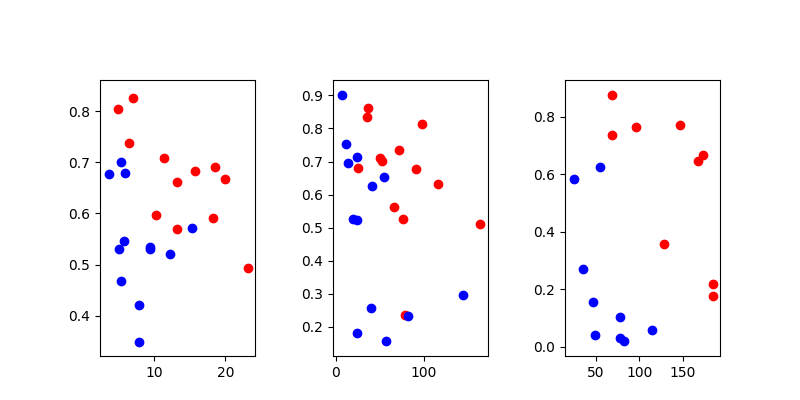

In [166]:
fig, axes = pl.subplots(1,3, figsize=(8,4)) 

ax=axes[0]
tmpd = residuals[residuals['visual_area']=='V1']
ax.scatter(np.array(tmpd['mse_az'].values).astype(float), np.array(tmpd['var_az'].values).astype(float), c='r')
ax.scatter(np.array(tmpd['mse_el'].values).astype(float), np.array(tmpd['var_el'].values).astype(float), c='b')

ax=axes[1]
tmpd = residuals[residuals['visual_area']=='Lm']
ax.scatter(np.array(tmpd['mse_az'].values).astype(float), np.array(tmpd['var_az'].values).astype(float), c='r')
ax.scatter(np.array(tmpd['mse_el'].values).astype(float), np.array(tmpd['var_el'].values).astype(float), c='b')


ax=axes[2]
tmpd = residuals[residuals['visual_area']=='Li']
ax.scatter(np.array(tmpd['mse_az'].values).astype(float), np.array(tmpd['var_az'].values).astype(float), c='r')
ax.scatter(np.array(tmpd['mse_el'].values).astype(float), np.array(tmpd['var_el'].values).astype(float), c='b')

pl.subplots_adjust(wspace=0.5, top=0.8)


<IPython.core.display.Javascript object>


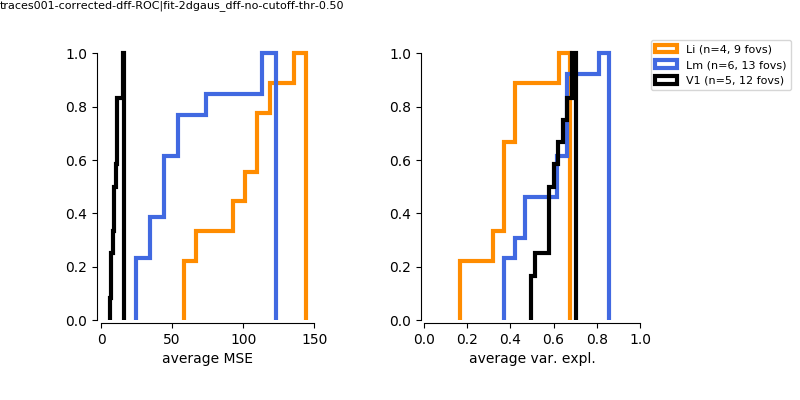

In [174]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in residuals.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd[['mse_el', 'mse_az']].mean(axis=1).values
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('average MSE')
    
    
    values = tmpd[['var_el', 'var_az']].mean(axis=1).values
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('average var. expl.')
    ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

sns.despine(ax=axes[0], trim=True, offset=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'mse_var_cdf.png'))

<IPython.core.display.Javascript object>


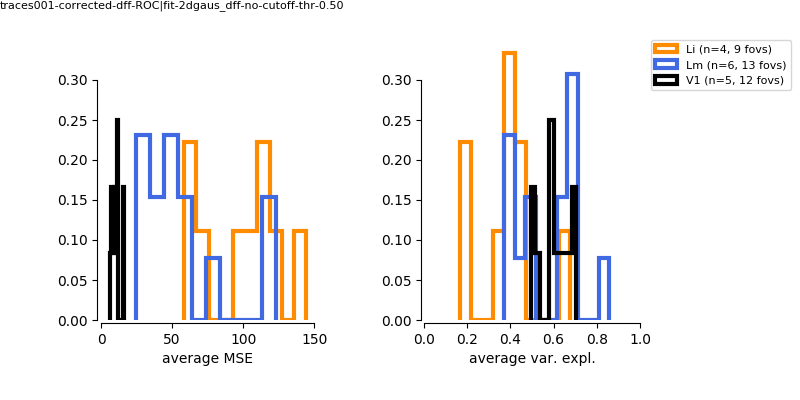

In [173]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in residuals.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd[['mse_el', 'mse_az']].mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('average MSE')
    
    
    values = tmpd[['var_el', 'var_az']].mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('average var. expl.')
    ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

sns.despine(ax=axes[0], trim=True, offset=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'mse_var_hist.png'))

In [ ]:
pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]

In [104]:
pf.head()


index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf   dist_az     mse_az   var_az   dist_el   mse_el  \
0  273.349886  5.655262  3.816403  15.694643  0.68203  2.608741  3.75284   
1  125.092321  1.460737 -2.346039  15.694643  0.68203 -3.114970  3.75284   
2  356.744767  4.182264  0.701298  15.694643  0.68203  1.995910  3.75284   
3  403.075256  2.775072  3.692497  15.694643  0.68203  1.066589  3.75284   
4  379.910012  2.955575  3.833411  15.694643  0.68203  1.008156  3.75284   

     var_el  
0  0.676879  
1  0.676879  
2  0.676879  
3  0.676879  
4  0.676879

In [ ]:
# Calculate pairwise distances

In [186]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')

In [222]:
def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv

animalid               JC076
fov            FOV1_zoom2p0x
mse                   265168
session             20190502
var                 -2.29637
visual_area               Li
dtype: object

In [411]:
pwres = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_fov', 'ypos_fov']])
    rdists = pdist(g[['xpos_rf', 'ypos_rf']])
    # Get linear fit:
    fitdist = fit_linear_regr(cdists, rdists)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    var = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'mse': mse,
                         'var': var})
    pwres.append(res)

pwdf = pd.concat(pwres, axis=1).T


<IPython.core.display.Javascript object>


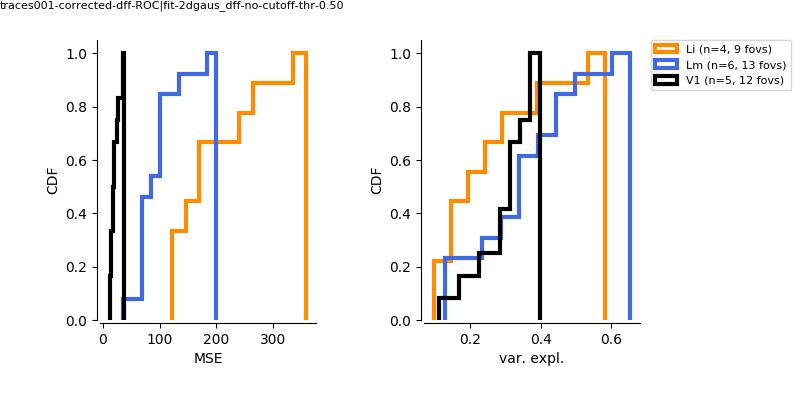

In [413]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwdf.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['mse'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('MSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['var'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('var. expl.')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'pairwise_distances_mse_var_cdf.png'))


In [410]:
tmpd

animalid            fov     mse   session      var visual_area
22    JC076  FOV1_zoom2p0x  258983  20190420 -4.34246          V1
23    JC076  FOV1_zoom2p0x  241211  20190501 -3.33603          V1
24    JC083  FOV1_zoom2p0x  155051  20190507 -3.98172          V1
25    JC083  FOV1_zoom2p0x  184434  20190510 -3.90412          V1
26    JC083  FOV1_zoom2p0x  140153  20190511 -3.89199          V1
27    JC084  FOV1_zoom2p0x  170734  20190522 -3.73816          V1
28    JC085  FOV1_zoom2p0x  211343  20190622 -2.93027          V1
29    JC097  FOV1_zoom2p0x  196126  20190613 -2.92274          V1
30    JC097  FOV1_zoom2p0x  245161  20190615 -3.07505          V1
31    JC097  FOV2_zoom2p0x  229314  20190615 -3.47872          V1
32    JC097  FOV1_zoom2p0x  213806  20190616  -3.2901          V1
33    JC097  FOV1_zoom2p0x  244329  20190617 -3.24287          V1

In [ ]:
# Look at PW distances of each session

In [240]:
tmpd = pf[pf['visual_area']=='V1']
print len(tmpd.groupby(['animalid', 'session', 'fov']))

12

<IPython.core.display.Javascript object>


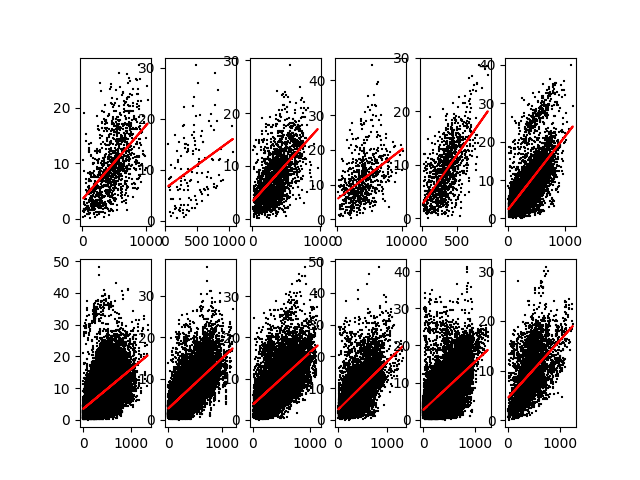

In [248]:
fig, axes = pl.subplots(2,6)

pw_tmp = []
ai = 0
for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
    ax = axes.flat[ai]
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_fov', 'ypos_fov']])
    rdists = pdist(g[['xpos_rf', 'ypos_rf']])
    # Get linear fit:
    fitdist = fit_linear_regr(cdists, rdists)
    mse = skmetrics.mean_squared_error(cdists, rdists)
    var = skmetrics.r2_score(cdists, rdists)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'mse': mse,
                         'var': var})
    pw_tmp.append(res)
    ax.scatter(cdists, rdists, c='k', marker='+', s=1)
    ax.plot(cdists, fitdist, 'r')
    ai += 1

pw_tmp = pd.concat(pw_tmp, axis=1).T


In [ ]:
# Save figures for each session

In [272]:
sessiondir = os.path.join(rfdir, 'sessions')
if not os.path.exists(sessiondir):
    os.makedirs(sessiondir)

In [ ]:
# test with 1 visual area first

In [358]:
visual_area = 'V1'

In [359]:

tmpd = pf[pf['visual_area']==visual_area]

tmpd_list = []
for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_fov', 'ypos_fov']])
    rdists = pdist(g[['xpos_rf', 'ypos_rf']])
    # Get linear fit:
    fitdist = fit_linear_regr(cdists, rdists)

    tmpd = pd.DataFrame({'cortical distance': cdists,
                        'RF distance': rdists,
                        'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
    tmpd_list.append(tmpd)
pw = pd.concat(tmpd_list, axis=0)

In [361]:
pw['dataset'].unique()

array(['JC076_20190420', 'JC076_20190501', 'JC083_20190507',
       'JC083_20190510', 'JC083_20190511', 'JC084_20190522',
       'JC085_20190622', 'JC097_20190613', 'JC097_20190615',
       'JC097_20190616', 'JC097_20190617'], dtype=object)

In [ ]:
# Plot regression for each dataset for each visual area

<IPython.core.display.Javascript object>


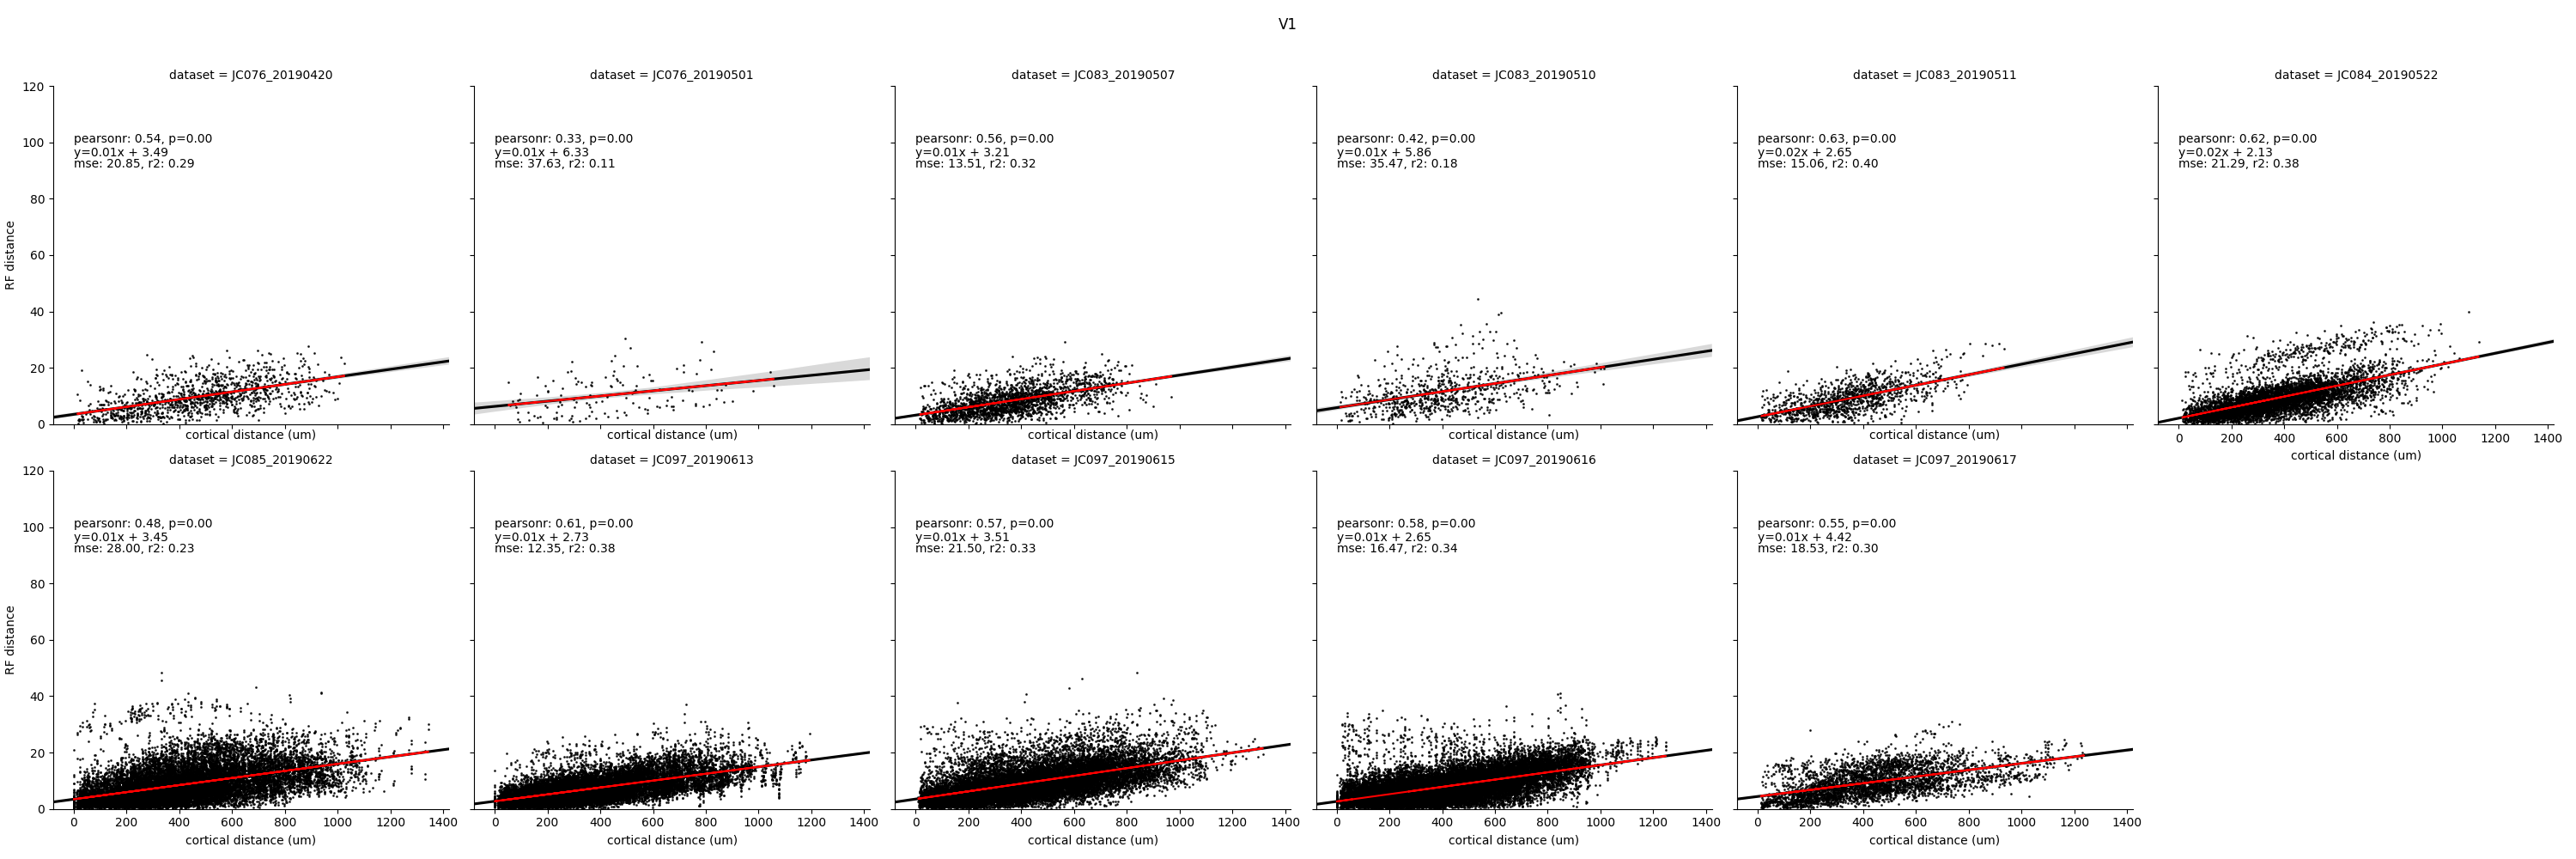

<IPython.core.display.Javascript object>


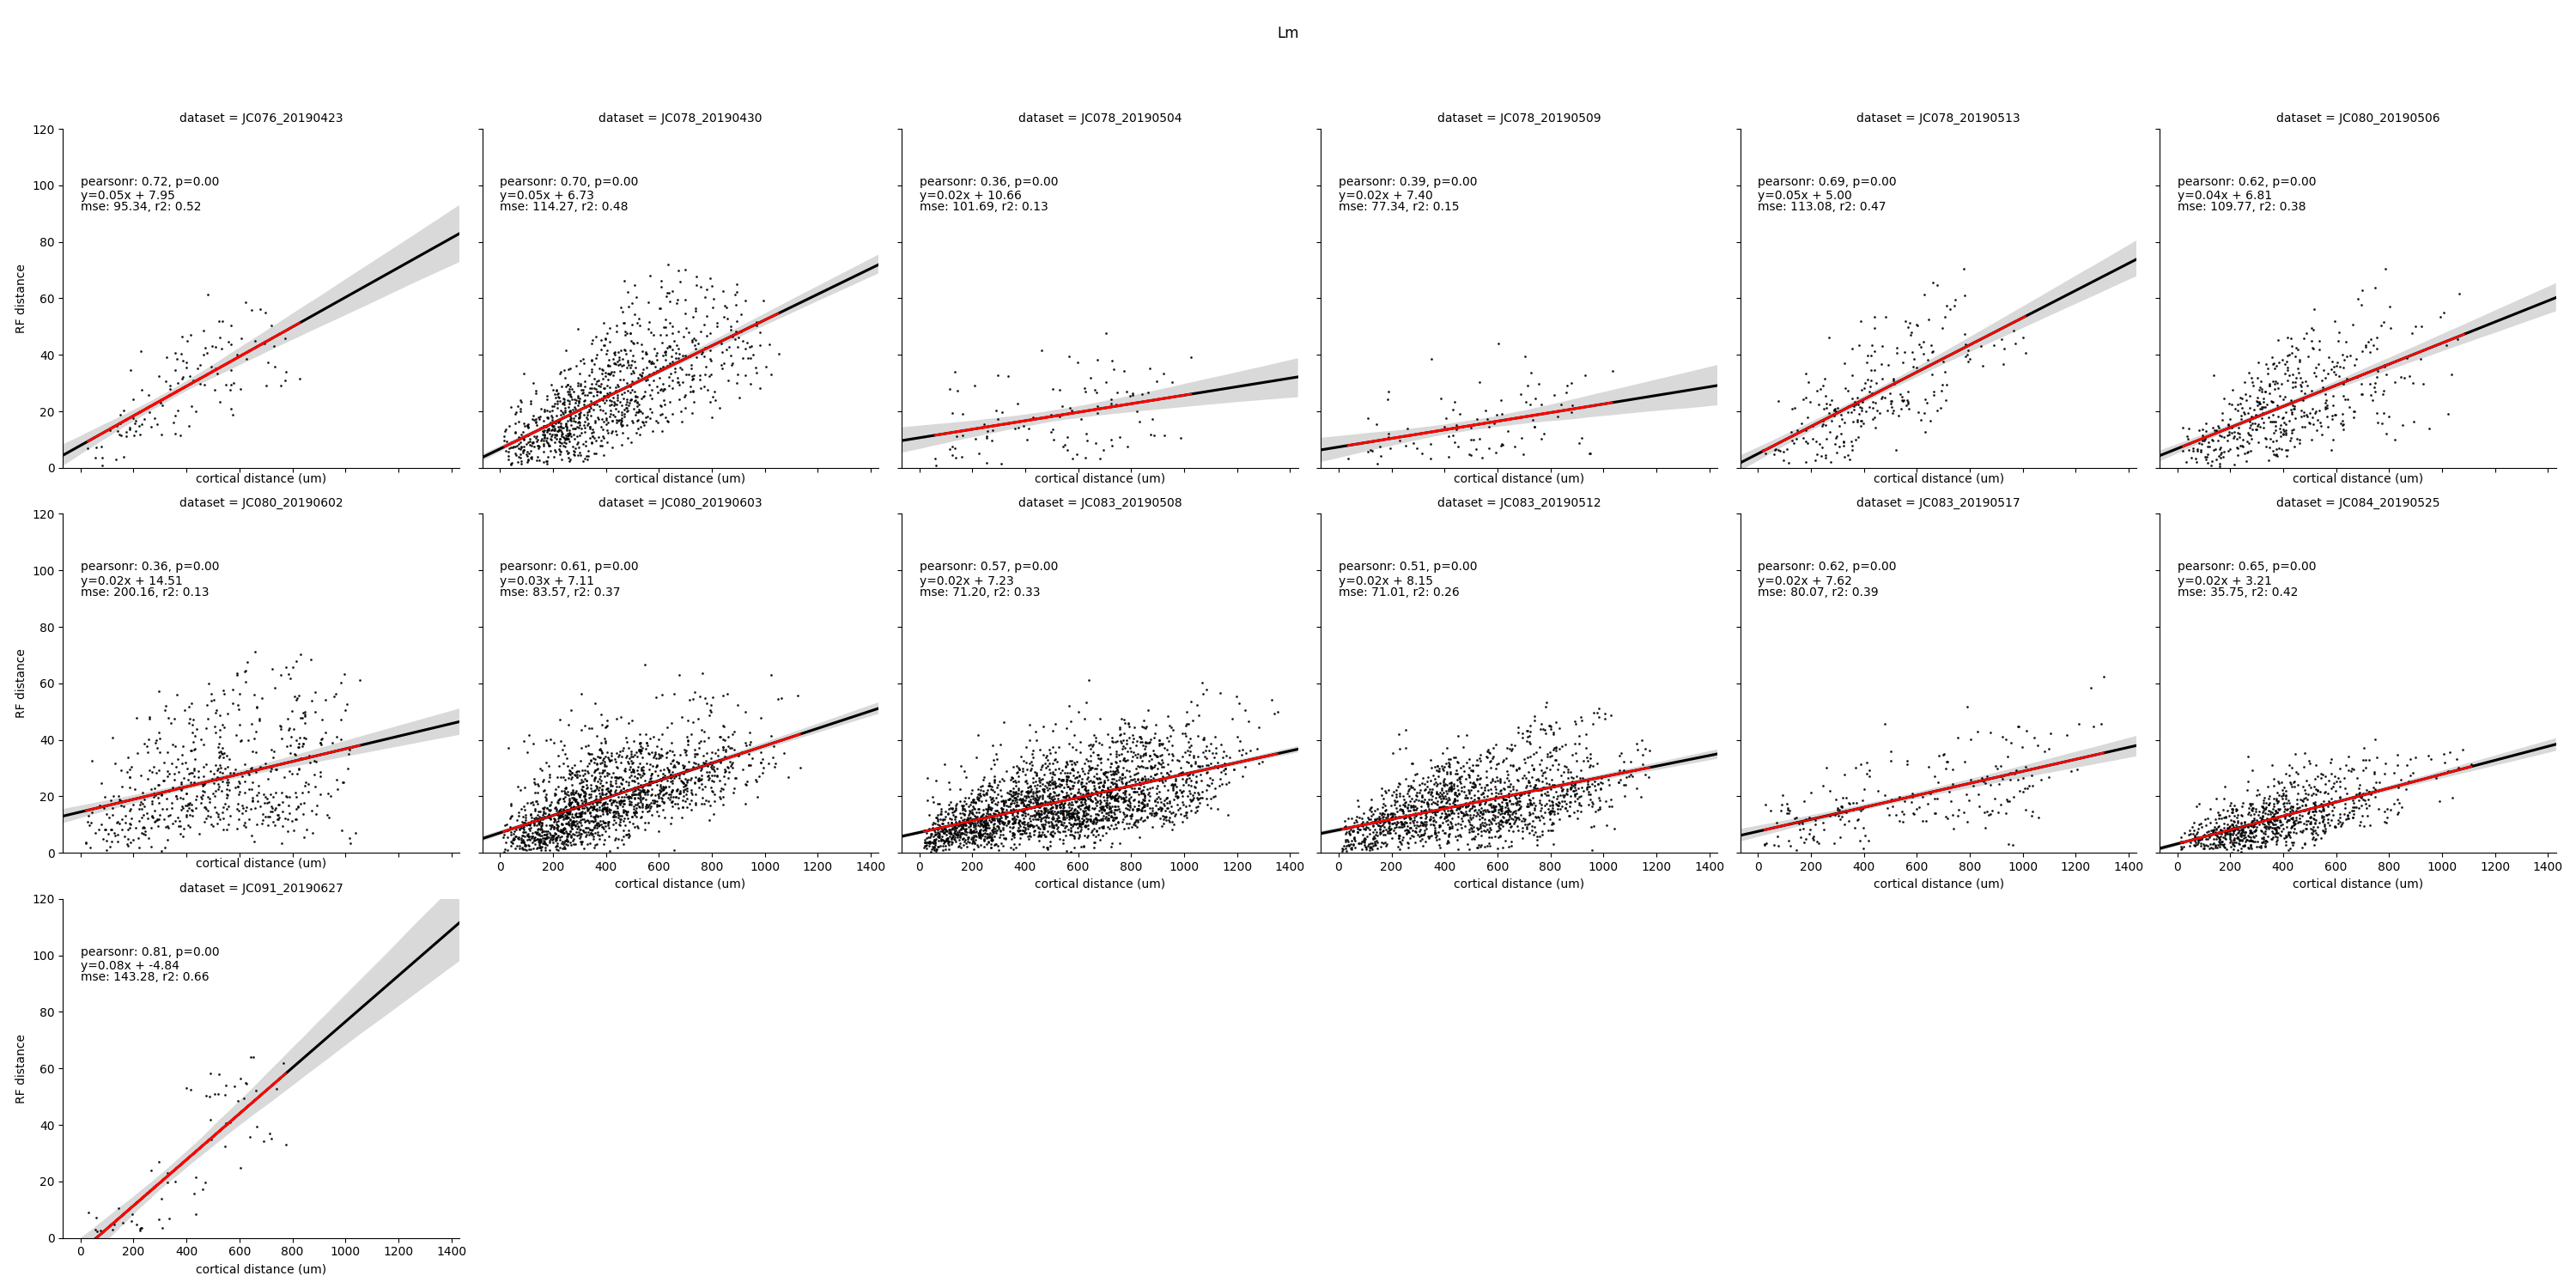

<IPython.core.display.Javascript object>


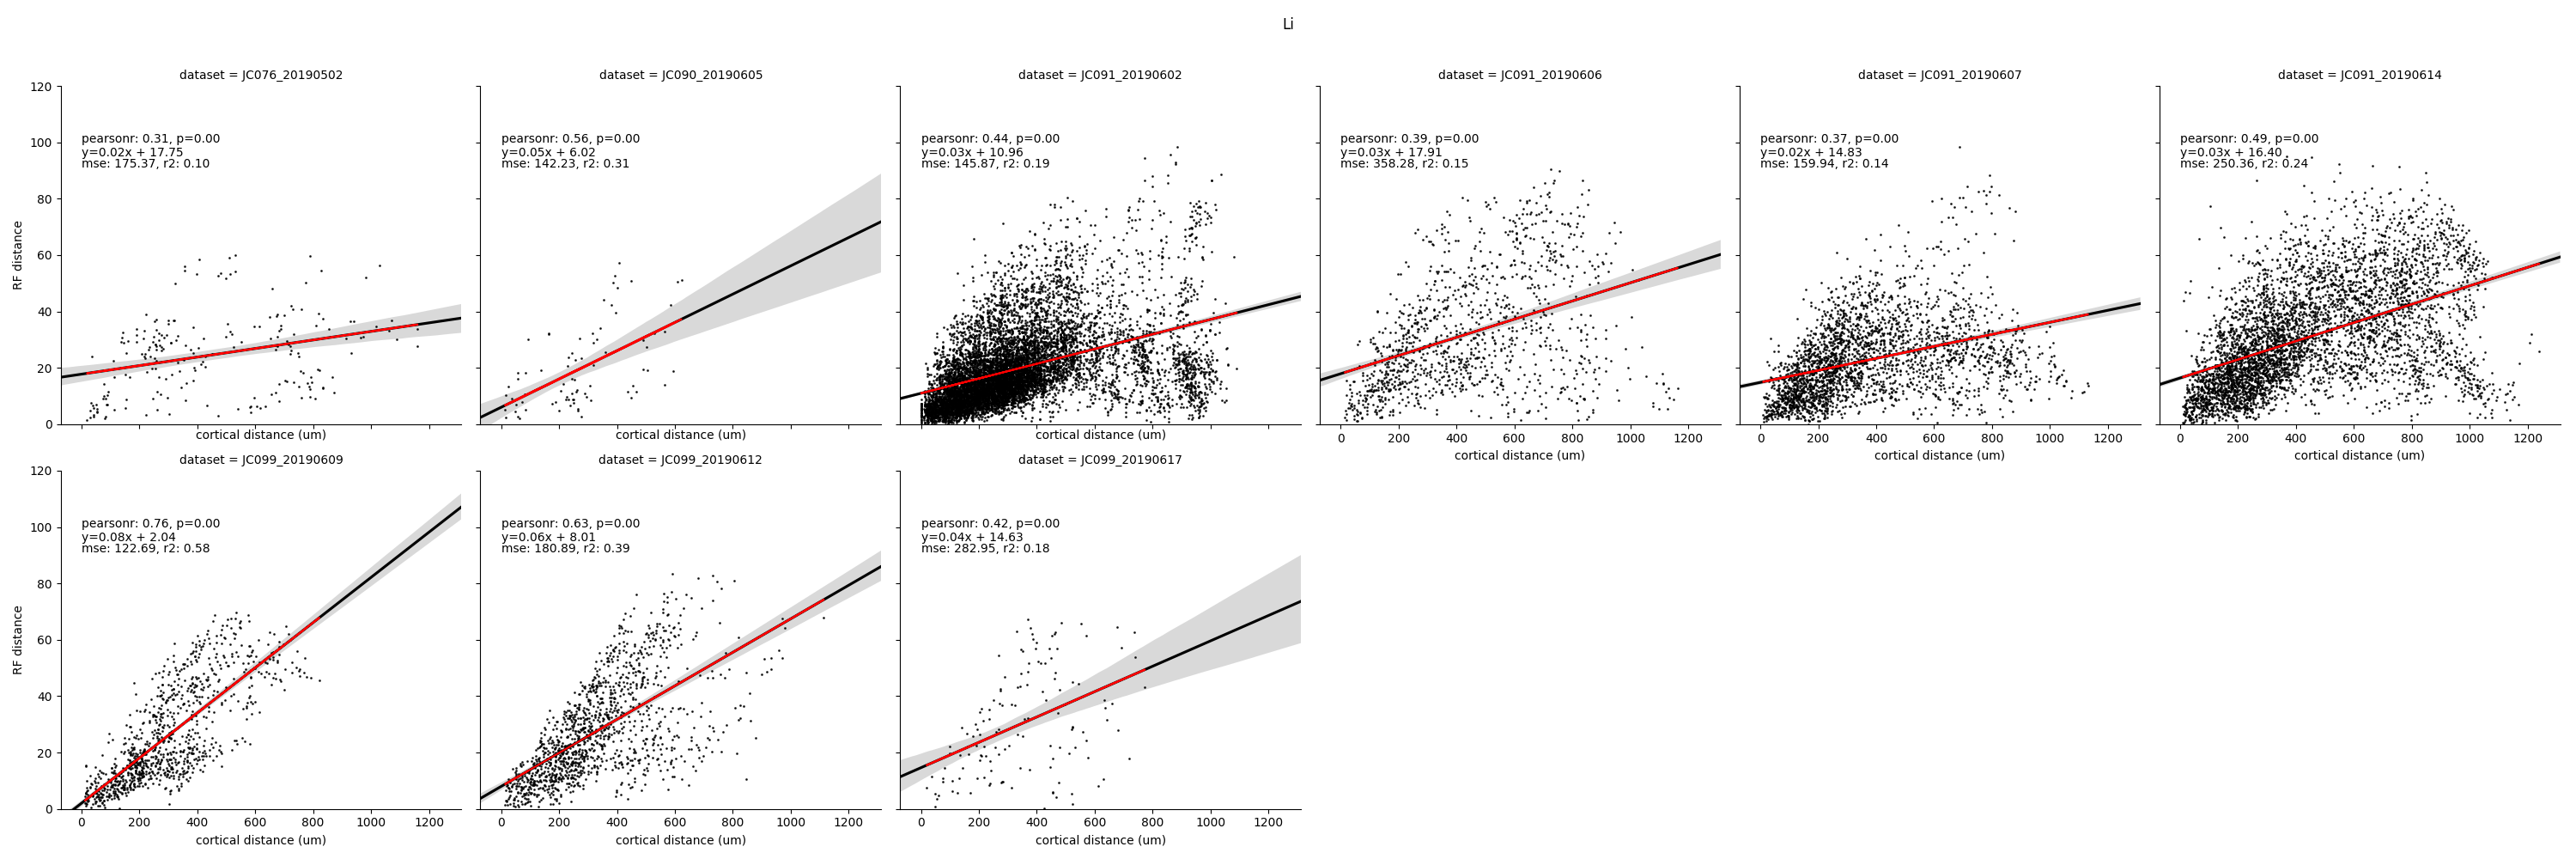

In [450]:
regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_fov', 'ypos_fov']])
        rdists = pdist(g[['xpos_rf', 'ypos_rf']])
        tmpd = pd.DataFrame({'cortical distance': cdists,
                            'RF distance': rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('cortical distance', 'RF distance', data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['cortical distance']
        yv = pw[pw['dataset']==curr_dset]['RF distance']
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        ax.text(0, 100, stat_str)
        ax.set_ylim([0, 120])
        ax.set_xlabel('cortical distance (um)')
        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.text(0, 95, slope_str)
        ax.text(0, 91, regr_str)
        regr_stats.append(pd.Series({'dataset': curr_dset,
                                   'mse': mse,
                                   'slope': float(regr.coef_),
                                   'intercept': float(regr.intercept_),
                                   'r2': r2,
                                    'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(sessiondir, '%s.png' % visual_area))


In [373]:
# Look at slope / intercept

In [422]:
reginfo = pd.concat(regr_stats, axis=1).T
reginfo.head()

dataset intercept      mse        r2       slope visual_area
0  JC076_20190420   3.49435  20.8538  0.291849   0.0133151          V1
1  JC076_20190501   6.32593  37.6282  0.110722  0.00917705          V1
2  JC083_20190507   3.21438  13.5118  0.317121   0.0141987          V1
3  JC083_20190510     5.859  35.4743  0.177895   0.0142868          V1
4  JC083_20190511   2.64958  15.0582   0.39773   0.0186305          V1

<IPython.core.display.Javascript object>


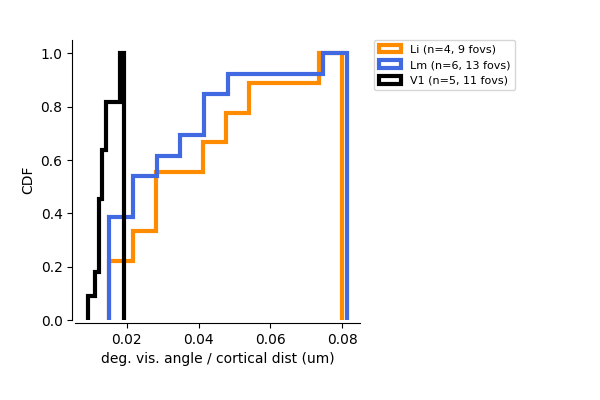

In [440]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, g in reginfo.groupby(['visual_area']):
    if use_slope:
        values = [s for s in g['slope'].values.astype(float)]
        xlabel = 'deg. vis. angle / cortical dist (um)'
    else:
        values = [1./s for s in g['slope'].values.astype(float)]
        xlabel = 'cortical dist (um) / deg vis. angle'
    
    dset_names = g['dataset'].unique()
    nrats = len(np.unique([n.split('_')[0] for n in dset_names]))
    nfovs = g['dataset'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(rfdir, 'slopes_cdf.png'))

In [437]:
reginfo['slope'] = reginfo['slope'].astype(float)

<IPython.core.display.Javascript object>


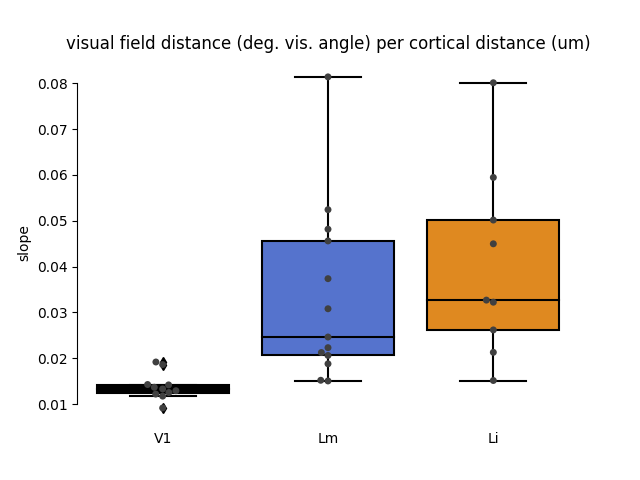

In [470]:
fig, ax = pl.subplots()
fig.patch.set_alpha(1)
sns.boxplot(x='visual_area', y='slope', data=reginfo, ax=ax, palette=area_colors)
ax = sns.swarmplot(x='visual_area', y='slope', data=reginfo, color=".25")
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(axis='x', length=0)
ax.set_xlabel('')
ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
pl.savefig(os.path.join(rfdir, 'pairwise_distances_regression_slopes_box.png'))

In [552]:
pairwisedir = os.path.join(rfdir, 'pairwise-distances')
if not os.path.exists(pairwisedir):
    os.makedirs(pairwisedir)

<IPython.core.display.Javascript object>


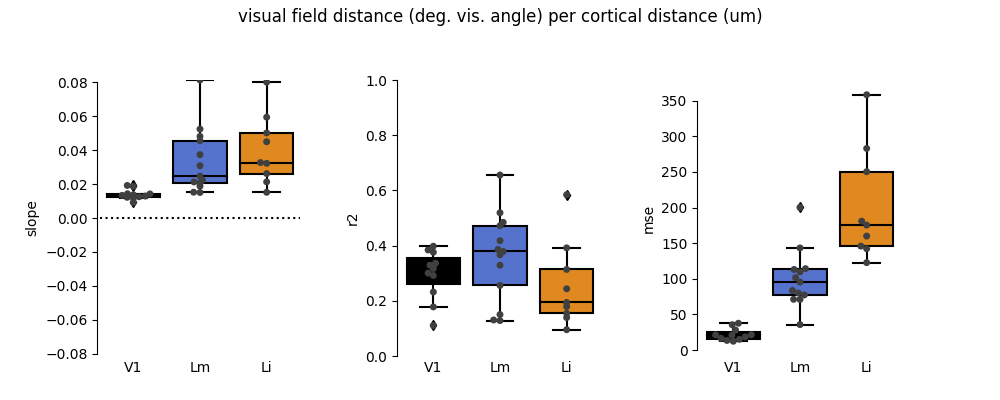

In [555]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(reginfo, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(reginfo, metric='r2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(reginfo, metric='mse', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('visual field distance (deg. vis. angle) per cortical distance (um)')

pl.savefig(os.path.join(pairwisedir, 'regression_stats.png'))

<IPython.core.display.Javascript object>


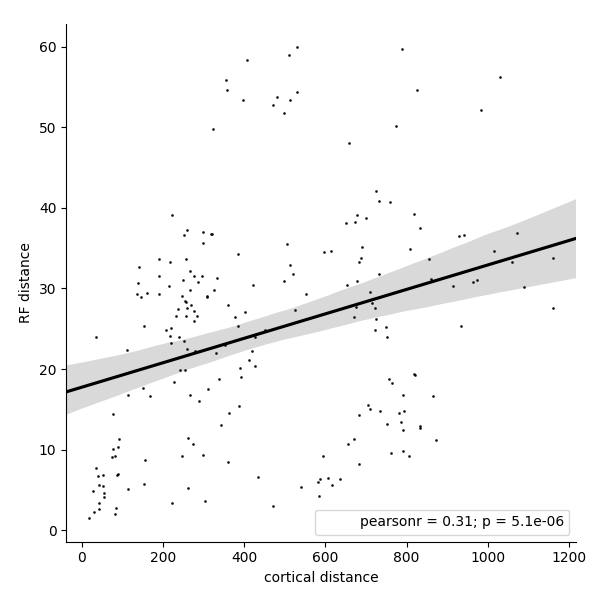

In [319]:

def r2(x, y):
    return spstats.pearsonr(x, y)[0] ** 2

tmpd = pw[pw['dataset']=='JC076_20190502']

g = sns.JointGrid(tmpd['cortical distance'], tmpd['RF distance'], ratio=100)
g.plot_joint(sns.regplot, scatter_kws=dict(s=1, marker='+', color='k'),
            line_kws=dict(color='k'))

# g= sns.jointplot(tmpd['cortical distance'], tmpd['RF distance'], kind="reg", stat_func=r2,
#                  joint_kws=dict(scatter_kws=dict(s=1)), marker='+', color='k')
                 
g.annotate(spstats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

In [231]:
tmpd

animalid            fov      mse   session      var visual_area
0    JC076  FOV1_zoom2p0x   265168  20190502 -2.29637          Li
1    JC090  FOV1_zoom2p0x  90449.8  20190605 -2.49908          Li
2    JC091  FOV1_zoom2p0x   147527  20190602 -1.88369          Li
3    JC091  FOV1_zoom2p0x   229523  20190606 -2.65192          Li
4    JC091  FOV1_zoom2p0x   176012  20190607 -2.08715          Li
5    JC091  FOV1_zoom2p0x   246527  20190614 -2.26863          Li
6    JC099  FOV1_zoom2p0x  96461.1  20190609 -2.58794          Li
7    JC099  FOV1_zoom2p0x   120488  20190612  -2.6544          Li
8    JC099  FOV1_zoom2p0x   131378  20190617  -3.3119          Li

In [232]:
values

array([265168.0997066003, 90449.753064985023, 147527.37548893155,
       229522.94176891772, 176011.90606705612, 246527.26546490268,
       96461.12960611195, 120487.91400357251, 131377.81979687951], dtype=object)

<IPython.core.display.Javascript object>


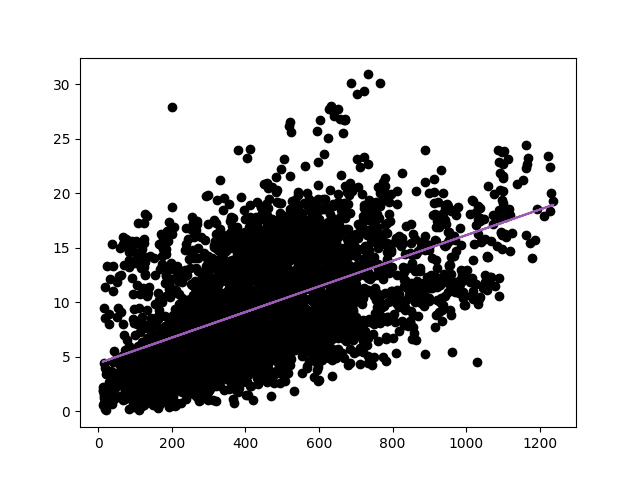

In [219]:
pl.figure()
pl.scatter(cdists, rdists, c='k')
pl.plot(cdists, fitdist)

In [213]:
import math  
def calcdist(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  
 

In [214]:
x1, y1 = g[['xpos_fov', 'ypos_fov']].iloc[0]
x2, y2 = g[['xpos_fov', 'ypos_fov']].iloc[1]
print calcdist(x1, y1, x2, y2) 

126.147422188


In [176]:
for k, g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    cdists = pdist(g[['xpos_fov', 'ypos_fov']])
    rdists = pdist(g[['xpos_rf', 'ypos_rf']])
    

xpos_fov    ypos_fov
0   41.969973  273.349886
1  267.081644  125.092321
2  129.725370  356.744767
3  120.186740  403.075256
4  146.894904  379.910012

In [200]:
cortical_distances = pdist(pf[pf['visual_area']==visual_area][['xpos_fov', 'ypos_fov']])
rf_distances = pdist(pf[pf['visual_area']==visual_area][['xpos_rf', 'ypos_rf']])


<IPython.core.display.Javascript object>


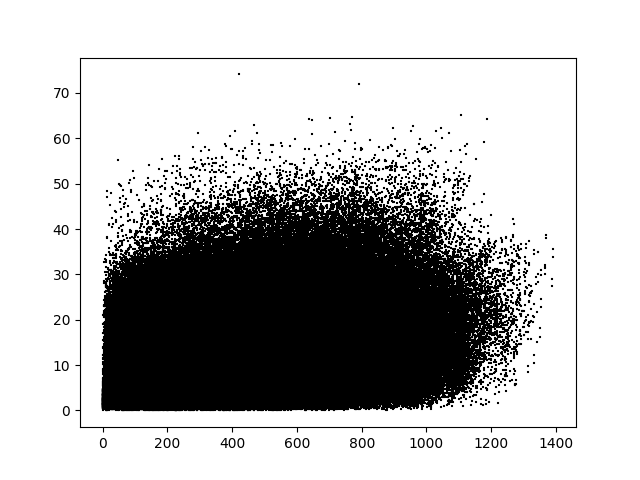

In [203]:
pl.figure()
pl.scatter(cortical_distances, rf_distances, c='k', marker='+', s=1)